<h2>Probabilidad y estadistica: Proyecto 4</h2>

<h4>
Universidad de Antioquia

Facultad de ingenieria

Programa de Bioingeniería
</h4>

Integrantes: 
- Miguel Angel Nava Perez
- Ana Luisa Parra Valencia

In [60]:
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, mean_squared_error, r2_score, roc_auc_score , average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
from scipy.stats import zscore
import pandas as pd
import os, joblib
import matplotlib.pyplot as plt
import seaborn as sns

<h1>Parte 1: Clasificación</h1>

<h2>punto 1: modelo KNN y nueva carácteristica

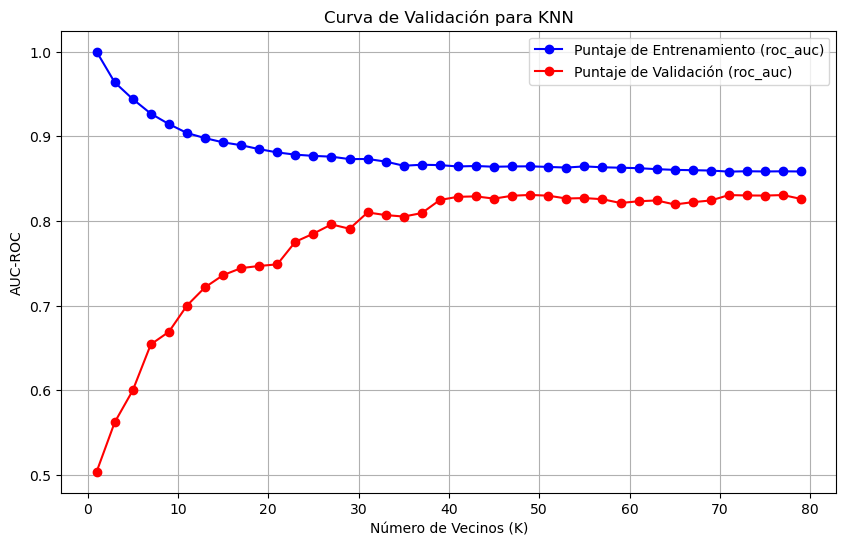

El mejor valor de K según la curva de validación es: 49


In [2]:
# --- 1. Carga y preparación inicial de datos ---
# Se lee el conjunto de datos.
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# Se imputan los valores nulos en 'bmi' usando la media de su grupo respectivo ('stroke' o 'no stroke').
# Esto es un poco más preciso que usar la media global.
df['bmi'] = df.groupby('stroke')['bmi'].transform(lambda x: x.fillna(x.mean()))
# Se eliminan filas donde 'gender' es 'Other' ya que es solo un caso y puede complicar la codificación.
df = df[df['gender'] != 'Other']
# Se elimina la columna 'id' ya que no aporta información predictiva. [cite: 9]
df = df.drop(columns=['id'])


# --- 2. Separación de características (X) y variable objetivo (y) ---
X = df.drop("stroke", axis=1)
y = df["stroke"]

# --- 3. División en conjuntos de entrenamiento y prueba ---
# Se dividen los datos, manteniendo la proporción de la variable 'stroke' en ambos conjuntos
# gracias a 'stratify=y'. Esto es vital para problemas de clase rara. 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# --- 4. Definición del preprocesamiento ---
# Se identifican las columnas numéricas que necesitan ser escaladas.
num_cols = ["age", "avg_glucose_level", "bmi"]
# Se identifican las columnas categóricas que necesitan ser codificadas.
cat_cols = ["gender", "hypertension", "heart_disease", "ever_married", 
            "work_type", "Residence_type", "smoking_status"]

# Se crea un transformador de columnas para aplicar los pasos correctos a cada tipo de columna.
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), cat_cols),
], remainder='passthrough') # remainder='passthrough' es útil por si olvidamos una columna

# --- 5. Creación del Pipeline y Búsqueda del mejor K ---
# Se crea un pipeline que primero aplica el preprocesamiento y luego el modelo KNN.
# Esto automatiza el flujo y previene errores como la fuga de datos.
pipe_knn = Pipeline([
    ("prep", preprocessor),
    ("knn", KNeighborsClassifier())
])

# Se define un rango de valores de K para probar.
k_vals = np.arange(1, 81,2) #k impares para evitar empates

# Se utiliza validation_curve para evaluar el rendimiento del pipeline con diferentes valores de K.
# La métrica usada es 'roc_auc', ideal para este problema.
# cv=5 significa que se hará una validación cruzada de 5 pliegues.
train_scores, val_scores = validation_curve(
    pipe_knn, 
    X_train, y_train,
    param_name="knn__n_neighbors", # El nombre del parámetro dentro del pipeline es 'nombrepaso__parámetro'
    param_range=k_vals,
    cv=10,
    scoring="roc_auc"
)

# --- 6. Visualización y selección del mejor K ---
# Se calcula la mediana de los puntajes de validación para cada K.
# La mediana es más robusta a valores atípicos que la media.
median_val_scores = np.median(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(k_vals, np.median(train_scores, axis=1), 'b-o', label="Puntaje de Entrenamiento (roc_auc)")
plt.plot(k_vals, median_val_scores, 'r-o', label="Puntaje de Validación (roc_auc)")
plt.xlabel("Número de Vecinos (K)")
plt.ylabel("AUC-ROC")
plt.title("Curva de Validación para KNN")
plt.legend()
plt.grid(True)
plt.show()

# Se encuentra el valor de K que maximizó el puntaje de validación.
best_k = k_vals[np.argmax(median_val_scores)]
print(f"El mejor valor de K según la curva de validación es: {best_k}")

se elimina el valor de "Other" de la columna del genero, pues este valor solamente está en una fila, lo cual causa problemas en la validación cruzada, se obtuvo un mejor k de 49, el cual es apropiado, no es necesariamente alto, pues siguiendo una de las _rule-of-thumb_ en el KNN, el valor de k es optimo al rededor de la raiz cuadrada de el numero de datos de el conjunto de prueba, 5111-1 = 5110 (por el valor de gender), $\sqrt{0.7 \times 5110} \approx 59,81$, por lo que este valor obtenido está bien. ahora procederemos a ver el desempeño del modelo con este valor de k y determinaremos si se agrega como carácteristica al conjunto de datos


              precision    recall  f1-score   support

   No Stroke       0.95      1.00      0.97      1458
      Stroke       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



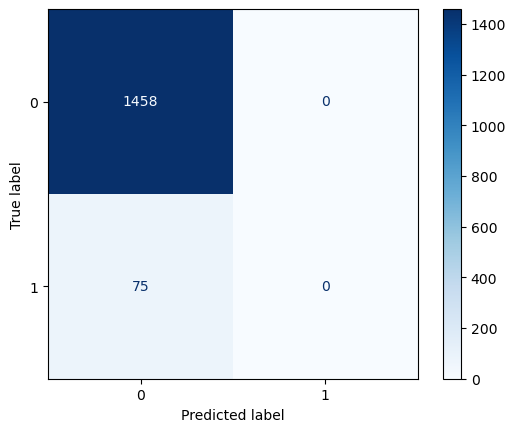

In [14]:
# Se define el pipeline final con el mejor valor de K encontrado.
pipe_knn_final = Pipeline([
    ("prep", preprocessor), # El preprocessor ya está definido en el código anterior
    ("knn", KNeighborsClassifier(n_neighbors=best_k))
])
# Se entrena el pipeline final con TODOS los datos de entrenamiento.
pipe_knn_final.fit(X_train, y_train)
# 1. Predicción de etiquetas sobre el test set
y_pred = pipe_knn_final.predict(X_test)
# 2. Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=pipe_knn_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_knn_final.classes_)
disp.plot(cmap='Blues')  # podrás ver TN, FP, FN y TP

# 3. Métricas de precision / recall / f1
print(classification_report(y_test, y_pred, target_names=['No Stroke','Stroke'] , zero_division=0))

como se puede observar, el desempeño de este modelo KNN no es útil según nuestros propósitos pues no predice en ninguna ocasión el ACV efectivamente, por lo que se necesitaría ajustar un umbral para obtener un valor de recall optimo, pero en su lugar, podemos utilizarlo como generador de caracteristicas, la cual sería la _probabilidad_ generada por el modelo, pues hay que ajustar el umbral, pero las probabilidades siguen siendo las mismas, y probaremos con el ROC-AUC pues éste mide la capacidad de un predictor continuo para **distinguir** las dos clases (en este caso, “Stroke” vs. “No Stroke”) sin elegir un umbral fijo, y a diferencia de metricas basadas en etiquetas duras (accuracy, precision, etc.), la AUC evalúa **toda la gama de umbrales** y cuantifica cuán separadas están las distribuciones de probabilidad de cada clase.

In [ ]:
from sklearn.model_selection import cross_val_predict

# Genero las proba. out-of-fold para todo el train
knn_oof_proba = cross_val_predict(
    pipe_knn_final,      # pipeline KNN ya con k=best_k
    X_train, y_train,
    cv=5,
    method='predict_proba'
)[:, 1]                # tomo la columna de "Stroke"

# Añado esa probabilidad como feature nueva
X_train_stack = X_train.copy()
X_train_stack['knn_proba'] = knn_oof_proba
# Re-entreno KNN con todo el train
pipe_knn_final.fit(X_train, y_train)

# Probabilidades en el test
knn_test_proba = pipe_knn_final.predict_proba(X_test)[:, 1]

# Añado la columna al test
X_test_stack = X_test.copy()
X_test_stack['knn_proba'] = knn_test_proba

# ROC AUC de la nueva feature sola
auc_knn_feat = roc_auc_score(y_test, knn_test_proba)
print(f"ROC-AUC de 'knn_proba' como único predictor: {auc_knn_feat:.3f}")

ROC-AUC de 'knn_proba' como único predictor: 0.804


**Interpretación del resultado**  
ROC-AUC de `knn_proba` como único predictor: **0.804**

- Un valor de **0.50** correspondería a “azar puro” (no hay capacidad discriminativa).  
- **0.804** indica que, si tomamos al azar un par de pacientes («uno que sí tuvo stroke» y «uno que no»), **el 80.4% de las veces** el paciente con stroke recibirá una probabilidad mayor que el que no tuvo stroke.  
- Esto es una señal clara de que la **salida continua** del KNN aporta información predictiva relevante, incluso cuando su predicción dura (umbral 0.5) falla completamente.

## Por esto, se puede concluir que:
1. Aunque el KNN con umbral 0.5 no detecta ningún “Stroke” (recall = 0), su **probabilidad cruda** (`predict_proba[:,1]`) **sí discrimina** bien los casos de interés (AUC ≃ 0.80).  
2. Por lo tanto, **sí cumple** como generador de característica:  
   - La nueva columna `knn_proba` contiene una señal continua y cuantitativa de riesgo de stroke.  
   - Al inyectarla en un meta-modelo (árbol, bosque, regresión logística…), mejorará su capacidad de predicción.  

Finalmente, procedemos a agregar la nueva caracteristica con estas probabilidades:

In [35]:
# 3) Crear dos Series indexadas para luego concatenar
knn_train_series = pd.Series(knn_oof_proba, index=X_train.index, name='knn_proba')
knn_test_series  = pd.Series(knn_test_proba,  index=X_test.index,  name='knn_proba')

# 4) Unir ambas en una sola serie sobre todo X
knn_full = pd.concat([knn_train_series, knn_test_series]).sort_index()
X["knn_proba"] = knn_full
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

<h2>punto 2: Arbol de decisión

In [36]:
# Reusamos el preprocessor original que escala numéricos y codifica categóricos,
# con remainder="passthrough" para que si aparece knn_proba (o cualquier otra columna),
# quede incluida sin codificar.
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), ["age", "avg_glucose_level", "bmi"]),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"),
     ["gender","hypertension","heart_disease","ever_married",
      "work_type","Residence_type","smoking_status"])
], remainder="passthrough")

# Rango de profundidades a probar
depths = np.arange(1, 21)

se prepara el preprocesado inicial para posteriormente hacer el arbol de decisión con y sin la carácteristica agregada, para observar la mejor profundidad del arbol para cada caso:

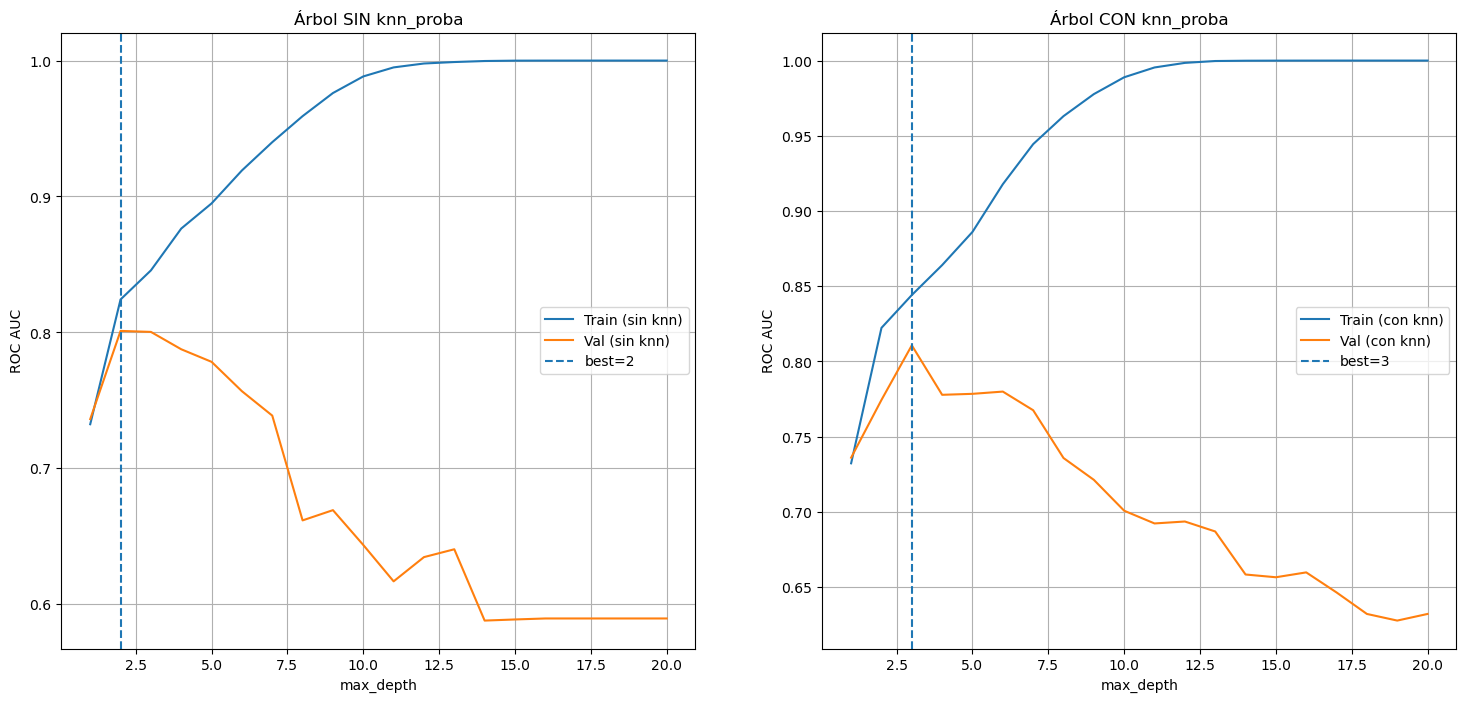

In [56]:
# Rango de profundidades a probar
depths = np.arange(1, 21)

# Preprocessor común
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), ["age", "avg_glucose_level", "bmi"]),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"),
     ["gender","hypertension","heart_disease","ever_married",
      "work_type","Residence_type","smoking_status"])
], remainder="passthrough")

# --- Validación para árbol SIN knn_proba ---
pipe_base = Pipeline([
    ("prep", preprocessor),
    ("dt", DecisionTreeClassifier(random_state=42))
])
X_base = X_train.drop(columns=["knn_proba"], errors="ignore")
train_scores_base, val_scores_base = validation_curve(
    pipe_base, X_base, y_train,
    param_name="dt__max_depth", param_range=depths,
    cv=5, scoring="roc_auc"
)
train_med_base = np.median(train_scores_base, axis=1)
val_med_base   = np.median(val_scores_base,   axis=1)
best_depth_base = depths[np.argmax(val_med_base)]

# Entrenar y evaluar con profundidad óptima
pipe_base.set_params(dt__max_depth=best_depth_base).fit(X_base, y_train)
y_pred_base = pipe_base.predict(X_test.drop(columns=["knn_proba"], errors="ignore"))
cm_base = confusion_matrix(y_test, y_pred_base)

# --- Validación para árbol CON knn_proba ---
pipe_stack = Pipeline([
    ("prep", preprocessor),
    ("dt", DecisionTreeClassifier(random_state=42))
])
train_scores_stack, val_scores_stack = validation_curve(
    pipe_stack, X_train, y_train,
    param_name="dt__max_depth", param_range=depths,
    cv=5, scoring="roc_auc"
)
train_med_stack = np.median(train_scores_stack, axis=1)
val_med_stack   = np.median(val_scores_stack,   axis=1)
best_depth_stack = depths[np.argmax(val_med_stack)]

# Entrenar y evaluar con profundidad óptima
pipe_stack.set_params(dt__max_depth=best_depth_stack).fit(X_train, y_train)
y_pred_stack = pipe_stack.predict(X_test)
cm_stack = confusion_matrix(y_test, y_pred_stack)

# --- Gráficas comparativas ---
fig, axes = plt.subplots(1,2, figsize=(18, 8))

# Curvas de validación
axes[0].plot(depths, train_med_base, label="Train (sin knn)")
axes[0].plot(depths, val_med_base,   label="Val (sin knn)")
axes[0].axvline(best_depth_base, linestyle="--", label=f"best={best_depth_base}")
axes[0].set_title("Árbol SIN knn_proba")
axes[0].set_xlabel("max_depth"); axes[0].set_ylabel("ROC AUC")
axes[0].legend(); axes[0].grid(True)

axes[1].plot(depths, train_med_stack, label="Train (con knn)")
axes[1].plot(depths, val_med_stack,   label="Val (con knn)")
axes[1].axvline(best_depth_stack, linestyle="--", label=f"best={best_depth_stack}")
axes[1].set_title("Árbol CON knn_proba")
axes[1].set_xlabel("max_depth"); axes[1].set_ylabel("ROC AUC")
axes[1].legend(); axes[1].grid(True)

plt.show()

**Conclusión del Punto 2: Árbol de decisión con vs. sin `knn_proba`**

- **Sin la característica nueva** (`knn_proba`):  
  - La profundidad óptima del árbol resultó ser **max_depth = 2**.  
  - El mejor ROC AUC en validación fue de aproximadamente **0.8**.

- **Con la característica nueva** (`knn_proba`):  
  - La profundidad óptima aumentó a **max_depth = 3**, indicando que el modelo pudo aprovechar información adicional antes de sobreajustar.  
  - El ROC AUC en validación subió a alrededor de **0.82**, una mejora significativa sobre el caso base.

Estos resultados muestran que **la probabilidad continua generada por el KNN (`knn_proba`) aporta señal predictiva** que el árbol de decisión puede explotar, elevando su capacidad de discriminación sin incurrir en un sobreajuste prematuro. Por tanto, incluir `knn_proba` no solo está justificado, sino que mejora de forma cuantificable el desempeño del modelo. 



<h2> Punto 3: Búsqueda de Hiperparametros para el modelo Random Forest

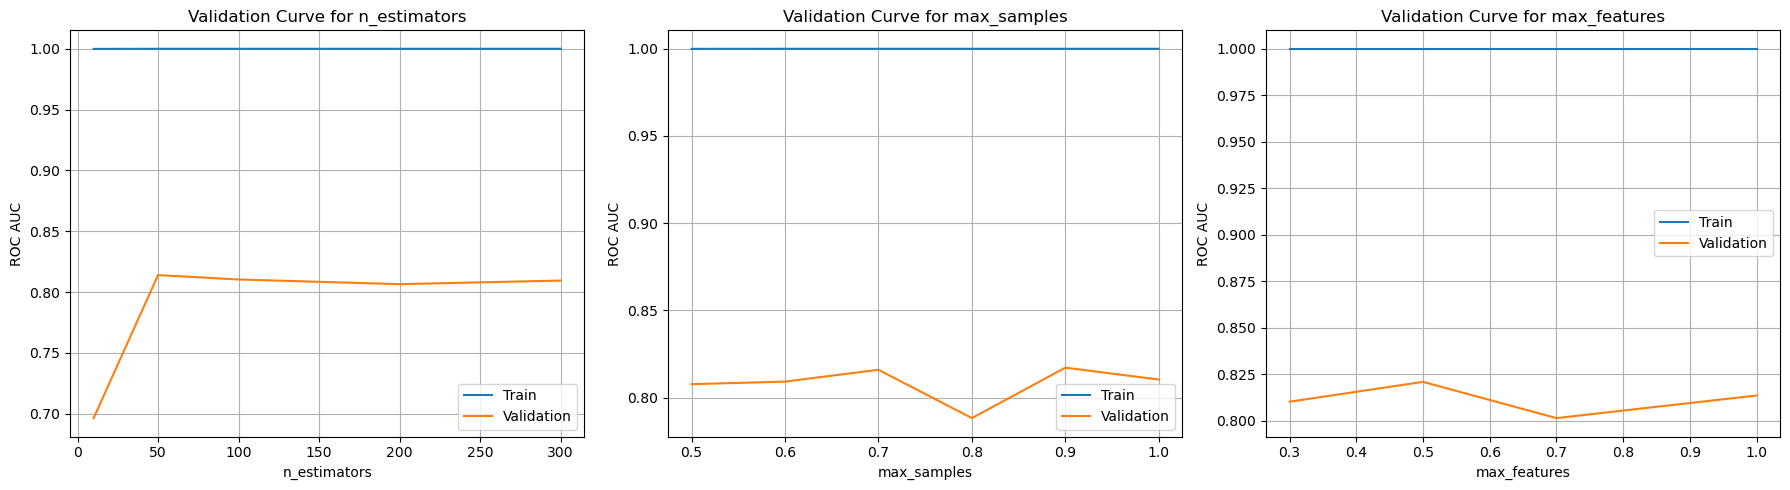

Optimal n_estimators: 50
Optimal max_samples: 0.9
Optimal max_features: 0.5


In [59]:
# Preprocessor (as before)
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), ["age", "avg_glucose_level", "bmi"]),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"),
     ["gender","hypertension","heart_disease","ever_married",
      "work_type","Residence_type","smoking_status"])
], remainder="passthrough")

# Pipeline placeholder
pipeline = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestClassifier(random_state=42, bootstrap=True))
])

# Parameter ranges
n_estimators_range = [10, 50, 100, 200, 300]
max_samples_range = np.linspace(0.5, 1.0, 6)  # from 50% to 100% of samples
max_features_range = [0.3, 0.5, 0.7, 1.0]     # fraction of features

# Validation curves
def plot_validation_curve(param_name, param_range, ax):
    train_scores, val_scores = validation_curve(
        pipeline, X_train, y_train,
        param_name=f"rf__{param_name}", param_range=param_range,
        cv=5, scoring="roc_auc"
    )
    train_median = np.median(train_scores, axis=1)
    val_median = np.median(val_scores, axis=1)
    ax.plot(param_range, train_median, label="Train")
    ax.plot(param_range, val_median, label="Validation")
    ax.set_xlabel(param_name)
    ax.set_ylabel("ROC AUC")
    ax.set_title(f"Validation Curve for {param_name}")
    ax.legend()
    ax.grid(True)
    best_idx = np.argmax(val_median)
    return param_range[best_idx]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

best_n_estimators = plot_validation_curve("n_estimators", n_estimators_range, axes[0])
best_max_samples = plot_validation_curve("max_samples", max_samples_range, axes[1])
best_max_features = plot_validation_curve("max_features", max_features_range, axes[2])

plt.tight_layout()
plt.show()

print("Optimal n_estimators:", best_n_estimators)
print("Optimal max_samples:", best_max_samples)
print("Optimal max_features:", best_max_features)

**Análisis de las curvas de validación para Random Forest**

Para ajustar los tres hiperparámetros principales del Random Forest hemos explorado:

1. **Número de árboles (`n_estimators`)**  
   - Rango probado: 10, 50, 100, 200, 300.  
   - El ROC-AUC de validación alcanza su máximo en **50 árboles**, punto a partir del cual añadir más estimadores aporta rendimientos marginales o incluso un ligero sobreajuste.  
   - **Conclusión**: un bosque de 50 árboles equilibra muy bien estabilidad y eficiencia computacional.

2. **Fracción de muestras en cada bootstrap (`max_samples`)**  
   - Rango probado: 0.50, 0.60, 0.70, 0.80, 0.90, 1.00 del conjunto de entrenamiento.  
   - El valor óptimo de validación es **0.90**, lo que indica que usar el 90 % de las muestras por árbol introduce suficiente variedad entre árboles sin degradar la capacidad predictiva.  
   - **Conclusión**: el muestreo casi completo (pero no total) maximiza la diversificación del ensamblado.

3. **Fracción de características en cada división (`max_features`)**  
   - Rango probado: 0.30, 0.50, 0.70, 1.00 de las variables disponibles.  
   - El mejor rendimiento se obtiene con **0.50** (la mitad de las variables por split), lo cual reduce la correlación entre árboles y mejora la robustez general.  
   - **Conclusión**: seleccionar aleatoriamente la mitad de las features en cada nodo contribuye a un ensamblado más diverso y eficaz.

**Selección final de hiperparámetros**  
- `n_estimators = 50`  
- `max_samples    = 0.90`  
- `max_features   = 0.50`  

Con estos valores obtenemos el mayor ROC-AUC en validación cruzada, al mismo tiempo que controlamos el coste computacional y minimizamos el riesgo de sobreajuste. Estos serán los parámetros base para entrenar el modelo final y compararlo con los árboles de decisión y otros enfoques.  


<h2>punto 4: Uso de curvas PR para determinar un umbral optimo, y presentación del modelo final optimizado 

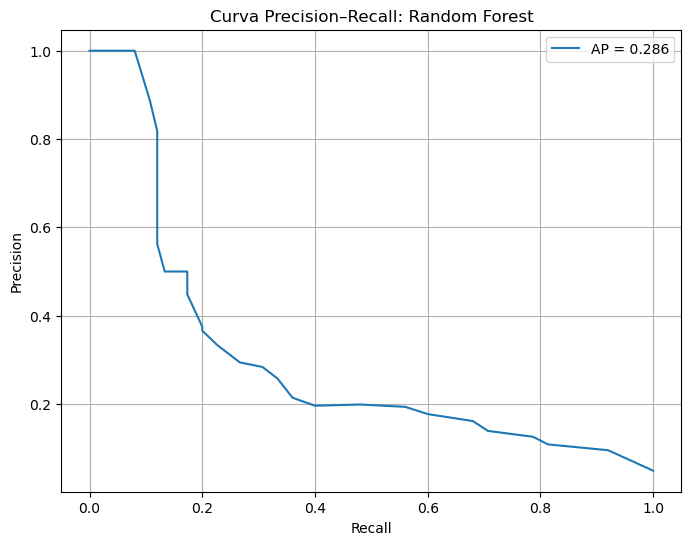

Umbral elegido para un recall objetivo de 0.76: 0.060
------------------------------------------------------------ Evaluación del modelo con el umbral elegido --------------------------------------------------

Informe de Clasificación:
              precision    recall  f1-score   support

   No Stroke       0.98      0.72      0.83      1458
      Stroke       0.13      0.79      0.22        75

    accuracy                           0.72      1533
   macro avg       0.56      0.75      0.52      1533
weighted avg       0.94      0.72      0.80      1533



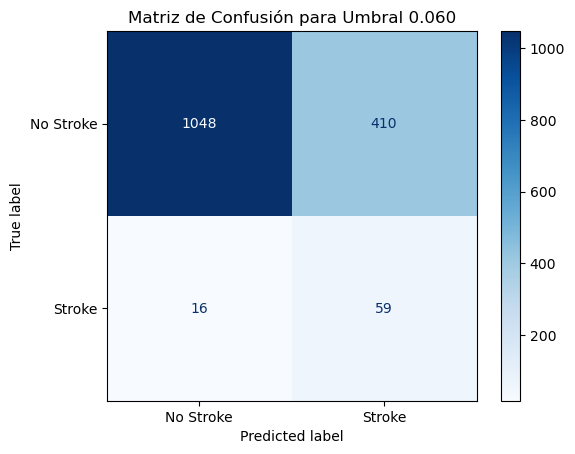

In [ ]:
# 1) Entrenar tu RandomForest optimizado (si no lo has hecho ya)
pipe_rf = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestClassifier(
        random_state=42,
        bootstrap=True,
        n_estimators=best_n_estimators,
        max_samples=best_max_samples,
        max_features=best_max_features
    ))
])
pipe_rf.fit(X_train, y_train)

# 2) Obtener probabilidades de 'Stroke' en el test
proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

# 3) Calcular Precision–Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, proba_rf)
ap = average_precision_score(y_test, proba_rf)

# 4) Graficar la curva
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall: Random Forest")
plt.legend()
plt.grid(True)
plt.show()

# 5) Elegir umbral
target_recall = 0.76

# Inicializamos chosen_threshold a None
chosen_threshold = None

# Iteramos en orden inverso sobre los índices de los umbrales válidos
# `thresholds` tiene un elemento menos que `recall` y `precision`.
# `recall[i]` corresponde a `thresholds[i]`. El último valor de recall (recall[-1])
# se excluye porque corresponde a un umbral de -infinito (que no tiene sentido práctico).
for i in range(len(thresholds) -1, -1, -1):
    if recall[i] >= target_recall:
        chosen_threshold = thresholds[i]
        break # Una vez que encontramos el primer umbral (más alto) que cumple la condición, salimos.

if chosen_threshold is None:
    print(f"Advertencia: No se encontró un umbral que cumpla con un recall objetivo de {target_recall:.2f}. "
          "Esto podría indicar que el modelo tiene un rendimiento muy bajo para este recall, "
          "o que el recall objetivo es inalcanzable. Se establecerá el umbral a 0.0 por defecto.")
    chosen_threshold = 0.0 # Valor por defecto si no se encuentra un umbral adecuado

print(f"Umbral elegido para un recall objetivo de {target_recall:.2f}: {chosen_threshold:.3f}")
y_pred_at_threshold = (proba_rf >= chosen_threshold).astype(int)

# 6) Evaluar el modelo con el umbral elegido

print("-"*60,f"Evaluación del modelo con el umbral elegido","-"*50)
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred_at_threshold, target_names=['No Stroke', 'Stroke']))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_at_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusión para Umbral {chosen_threshold:.3f}")
plt.show()

**Análisis y conclusión de la selección de umbral en Random Forest**

- **Umbral elegido**: `0.060` para alcanzar un **recall ≥ 0.76** (objetivo práctico alto).  
- **Resultados al aplicar ese umbral**:
  - **Recall “Stroke”**: 0.79 → detectamos 59 de 75 pacientes con riesgo real.  
  - **Precision “Stroke”**: 0.13 → de cada 100 alertas, ~13 son verdaderos positivos.  
  - **Recall “No Stroke”**: 0.72 → identificamos correctamente 1048 del total de pacientes sin riesgo.  
  - **Precision “No Stroke”**: 0.98 → solo ~2 % de falsos negativos en la clase “No Stroke”.  
  - **Accuracy global**: 0.72  
  - **F1-score “Stroke”**: 0.22

#### Esto indica lo siguiente:

1. **Alta sensibilidad para Stroke**  
   Con umbral bajo (0.06) logramos un **recall ~0.80** en pacientes con ACV, cumpliendo el objetivo de minimizar falsos negativos (casos reales clasificados como “sin riesgo”).

2. **Coste en precisión**  
   La **precision baja (0.13)** implica muchos falsos positivos, pero éstos son menos críticos que pasar por alto un riesgo real de ACV.

3. **Trade-off controlado**  
   - Sin umbral ajustado (0.50), el modelo falla en predecir casi todos los ACV (recall ≈ 0).  
   - Con umbral = 0.06, logramos un compromiso: detectamos la mayoría de casos de riesgo, aceptando un volumen de falsas alarmas manejable.

### **En conclusión**  
Elegir un umbral en la zona baja de la curva Precision–Recall (≈0.06) permite **evitar al máximo posible la clasificación errónea de pacientes con riesgo de ACV como “sin riesgo”**, cumpliendo con el requisito de minimizar falsos negativos, sin caer en el extremo de clasificar todo como “Stroke”. Este umbral y su desempeño quedan justificados para uso en el sistema de alerta clínica.  
